<a href="https://colab.research.google.com/github/fzadib/3DUnetCNN/blob/master/Brain_Tumor_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [ ]:
from tqdm import tqdm
import os
import time
from random import randint

import gc
import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib
import pydicom as pdm
import nilearn as nl
import nilearn.plotting as nlplt
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output
from IPython.display import YouTubeVideo

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss



from albumentations import Compose, HorizontalFlip

import warnings
warnings.simplefilter("ignore")

# Data loading

In [ ]:
cw0 = time.time()
dl0 = time.time()

In [ ]:
sample_filename = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii'
sample_filename_mask = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii'
sample_img = nib.load(sample_filename)
sample_img = np.asanyarray(sample_img.dataobj)
sample_img = np.rot90(sample_img)
sample_mask = nib.load(sample_filename_mask)
sample_mask = np.asanyarray(sample_mask.dataobj)
sample_mask = np.rot90(sample_mask)
print("img shape ->", sample_img.shape)
print("mask shape ->", sample_mask.shape)

img shape -> (240, 240, 155)
mask shape -> (240, 240, 155)


In [ ]:
sample_filename2 = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii'
sample_img2 = nib.load(sample_filename2)
sample_img2 = np.asanyarray(sample_img2.dataobj)
sample_img2  = np.rot90(sample_img2)
sample_filename3 = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii'
sample_img3 = nib.load(sample_filename3)
sample_img3 = np.asanyarray(sample_img3.dataobj)
sample_img3  = np.rot90(sample_img3)
sample_filename4 = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii'
sample_img4 = nib.load(sample_filename4)
sample_img4 = np.asanyarray(sample_img4.dataobj)
sample_img4  = np.rot90(sample_img4)

mask_WT = sample_mask.copy()
mask_WT[mask_WT == 1] = 1
mask_WT[mask_WT == 2] = 1
mask_WT[mask_WT == 4] = 1

mask_TC = sample_mask.copy()
mask_TC[mask_TC == 1] = 1
mask_TC[mask_TC == 2] = 0
mask_TC[mask_TC == 4] = 1

mask_ET = sample_mask.copy()
mask_ET[mask_ET == 1] = 0
mask_ET[mask_ET == 2] = 0
mask_ET[mask_ET == 4] = 1

In [ ]:
# total data loading time(dlt)
dl1 = time.time()
dlt = dl1 - dl0
print("Data loading time : ", dlt )

Data loading time :  0.2371199131011963


# Sample data visualization

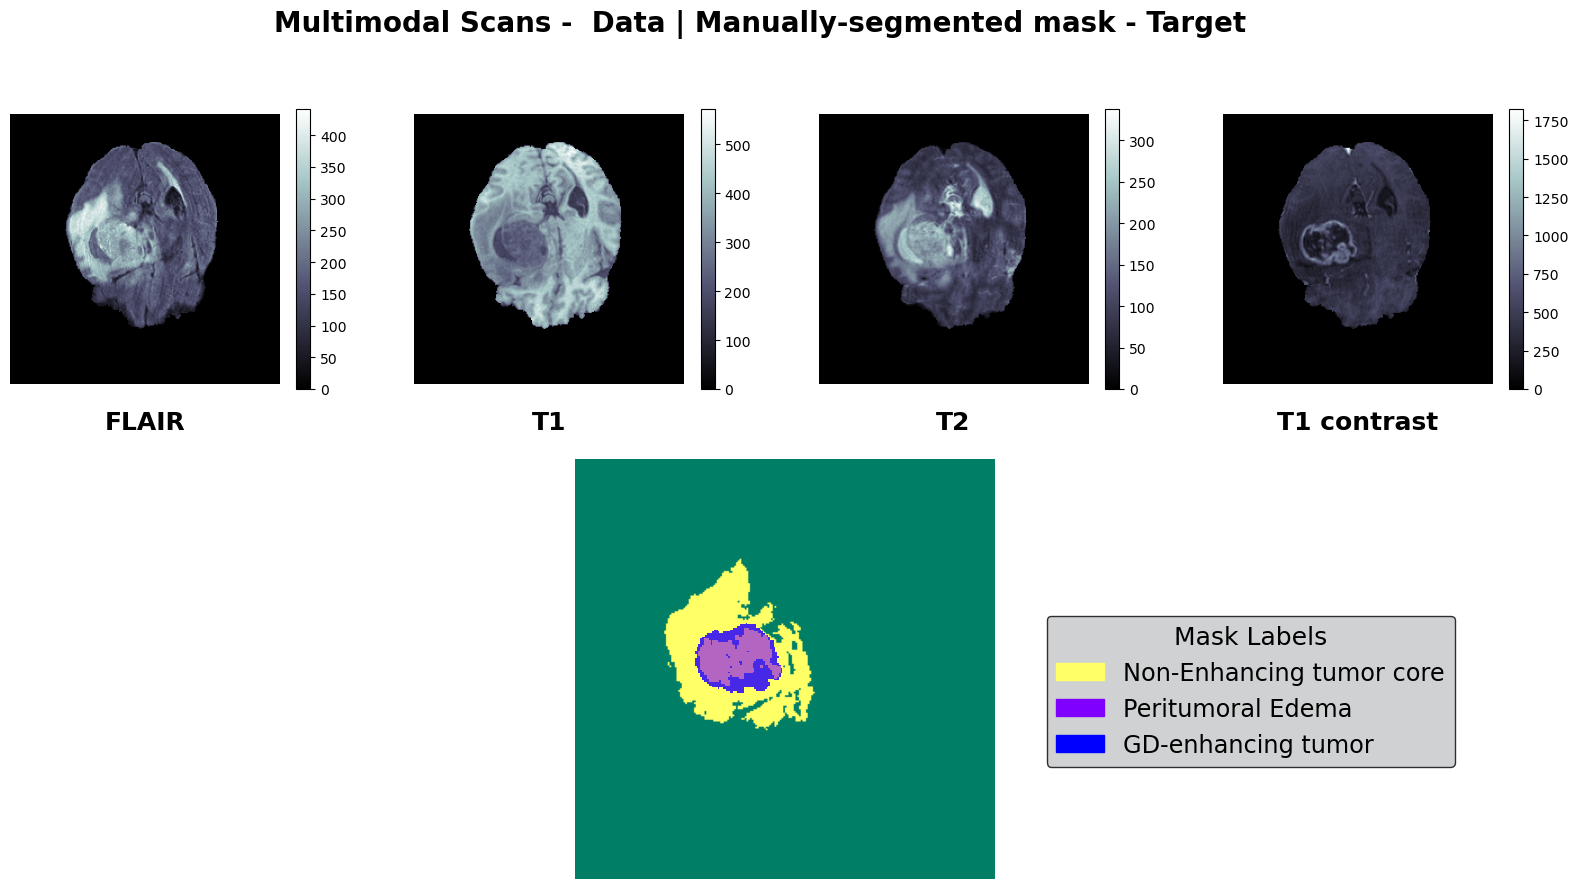

In [ ]:
fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 1.5])
ax0 = fig.add_subplot(gs[0, 0])
flair = ax0.imshow(sample_img[:,:,65], cmap='bone')
ax0.set_title("FLAIR", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(flair)

ax1 = fig.add_subplot(gs[0, 1])
t1 = ax1.imshow(sample_img2[:,:,65], cmap='bone')
ax1.set_title("T1", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1)
ax2 = fig.add_subplot(gs[0, 2])
t2 = ax2.imshow(sample_img3[:,:,65], cmap='bone')
ax2.set_title("T2", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t2)
ax3 = fig.add_subplot(gs[0, 3])
t1ce = ax3.imshow(sample_img4[:,:,65], cmap='bone')
ax3.set_title("T1 contrast", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1ce)

ax4 = fig.add_subplot(gs[1, 1:3])
l1 = ax4.imshow(mask_WT[:,:,65], cmap='summer',)
l2 = ax4.imshow(np.ma.masked_where(mask_TC[:,:,65]== False,  mask_TC[:,:,65]), cmap='rainbow', alpha=0.6)
l3 = ax4.imshow(np.ma.masked_where(mask_ET[:,:,65] == False, mask_ET[:,:,65]), cmap='winter', alpha=0.6)

ax4.set_title("", fontsize=20, weight='bold', y=-0.1)

_ = [ax.set_axis_off() for ax in [ax0,ax1,ax2,ax3, ax4]]

colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
labels = ['Non-Enhancing tumor core', 'Peritumoral Edema ', 'GD-enhancing tumor']
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 'xx-large',
           title='Mask Labels', title_fontsize=18, edgecolor="black",  facecolor='#c5c6c7')

plt.suptitle("Multimodal Scans -  Data | Manually-segmented mask - Target", fontsize=20, weight='bold')

fig.savefig("data_sample.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("data_sample.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

# Image conversions - 2D , 3D & GIF

In [ ]:
class Image3dToGIF3d:
    def __init__(self,
                 img_dim: tuple = (55, 55, 55),
                 figsize: tuple = (15, 10),
                 binary: bool = False,
                 normalizing: bool = True,
                ):
        """Initialization."""
        self.img_dim = img_dim
        print(img_dim)
        self.figsize = figsize
        self.binary = binary
        self.normalizing = normalizing

    def _explode(self, data: np.ndarray):
        shape_arr = np.array(data.shape)
        size = shape_arr[:3] * 2 - 1
        exploded = np.zeros(np.concatenate([size, shape_arr[3:]]),
                            dtype=data.dtype)
        exploded[::2, ::2, ::2] = data
        return exploded

    def _expand_coordinates(self, indices: np.ndarray):
        x, y, z = indices
        x[1::2, :, :] += 1
        y[:, 1::2, :] += 1
        z[:, :, 1::2] += 1
        return x, y, z

    def _normalize(self, arr: np.ndarray):
        arr_min = np.min(arr)
        return (arr - arr_min) / (np.max(arr) - arr_min)


    def _scale_by(self, arr: np.ndarray, factor: int):

        mean = np.mean(arr)
        return (arr - mean) * factor + mean

    def get_transformed_data(self, data: np.ndarray):
        if self.binary:
            resized_data = resize(data, self.img_dim, preserve_range=True)
            return np.clip(resized_data.astype(np.uint8), 0, 1).astype(np.float32)

        norm_data = np.clip(self._normalize(data)-0.1, 0, 1) ** 0.4
        scaled_data = np.clip(self._scale_by(norm_data, 2) - 0.1, 0, 1)
        resized_data = resize(scaled_data, self.img_dim, preserve_range=True)

        return resized_data

    def plot_cube(self,
                  cube,
                  title: str = '',
                  init_angle: int = 0,
                  make_gif: bool = False,
                  path_to_save: str = 'filename.gif'
                 ):

        if self.binary:
            facecolors = cm.winter(cube)
            print("binary")
        else:
            if self.normalizing:
                cube = self._normalize(cube)
            facecolors = cm.gist_stern(cube)
            print("not binary")

        facecolors[:,:,:,-1] = cube
        facecolors = self._explode(facecolors)

        filled = facecolors[:,:,:,-1] != 0
        x, y, z = self._expand_coordinates(np.indices(np.array(filled.shape) + 1))

        with plt.style.context("dark_background"):

            fig = plt.figure(figsize=self.figsize)
            ax = fig.gca(projection='3d')

            ax.view_init(30, init_angle)
            ax.set_xlim(right = self.img_dim[0] * 2)
            ax.set_ylim(top = self.img_dim[1] * 2)
            ax.set_zlim(top = self.img_dim[2] * 2)
            ax.set_title(title, fontsize=18, y=1.05)

            ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)

            if make_gif:
                images = []
                for angle in tqdm(range(0, 360, 5)):
                    ax.view_init(30, angle)
                    fname = str(angle) + '.png'

                    plt.savefig(fname, dpi=120, format='png', bbox_inches='tight')
                    images.append(imageio.imread(fname))
                    #os.remove(fname)
                imageio.mimsave(path_to_save, images)
                plt.close()

            else:
                plt.show()


class ShowResult:

    def mask_preprocessing(self, mask):
        mask = mask.squeeze().cpu().detach().numpy()
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        mask_WT = np.rot90(montage(mask[0]))
        mask_TC = np.rot90(montage(mask[1]))
        mask_ET = np.rot90(montage(mask[2]))

        return mask_WT, mask_TC, mask_ET

    def image_preprocessing(self, image):
        """
        Returns image flair as mask for overlaping gt and predictions.
        """
        image = image.squeeze().cpu().detach().numpy()
        image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 2, 1))
        flair_img = np.rot90(montage(image[0]))
        return flair_img

    def plot(self, image, ground_truth, prediction):
        image = self.image_preprocessing(image)
        gt_mask_WT, gt_mask_TC, gt_mask_ET = self.mask_preprocessing(ground_truth)
        pr_mask_WT, pr_mask_TC, pr_mask_ET = self.mask_preprocessing(prediction)

        fig, axes = plt.subplots(1, 2, figsize = (35, 30))

        [ax.axis("off") for ax in axes]
        axes[0].set_title("Ground Truth", fontsize=35, weight='bold')
        axes[0].imshow(image, cmap ='bone')
        axes[0].imshow(np.ma.masked_where(gt_mask_WT == False, gt_mask_WT),
                  cmap='cool_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_TC == False, gt_mask_TC),
                  cmap='autumn_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_ET == False, gt_mask_ET),
                  cmap='autumn', alpha=0.6)

        axes[1].set_title("Prediction", fontsize=35, weight='bold')
        axes[1].imshow(image, cmap ='bone')
        axes[1].imshow(np.ma.masked_where(pr_mask_WT == False, pr_mask_WT),
                  cmap='cool_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_TC == False, pr_mask_TC),
                  cmap='autumn_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_ET == False, pr_mask_ET),
                  cmap='autumn', alpha=0.6)

        plt.tight_layout()

        plt.show()


def merging_two_gif(path1: str, path2: str, name_to_save: str):
    #Create reader object for the gif
    gif1 = imageio.get_reader(path1)
    gif2 = imageio.get_reader(path2)
    number_of_frames = min(gif1.get_length(), gif2.get_length())

    #Create writer object
    new_gif = imageio.get_writer(name_to_save)

    for frame_number in range(number_of_frames):
        img1 = gif1.get_next_data()
        img2 = gif2.get_next_data()
        #here is the magic
        new_image = np.hstack((img1, img2))
        new_gif.append_data(new_image)

    gif1.close()
    gif2.close()
    new_gif.close()


def get_all_csv_file(root: str) -> list:
    ids = []
    for dirname, _, filenames in os.walk(root):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            if path.endswith(".csv"):
                ids.append(path)
    ids = list(set(filter(None, ids)))
    print(f"Extracted {len(ids)} csv files.")
    return ids

In [ ]:
class GlobalConfig:
    root_dir = '../input/brats20-dataset-training-validation'
    train_root_dir = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    test_root_dir = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
    path_to_csv = './train_data.csv'
    pretrained_model_path = '../input/brats20logs/brats2020logs/unet/last_epoch_model.pth'
    train_logs_path = '../input/brats20logs/brats2020logs/unet/train_log.csv'
    ae_pretrained_model_path = '../input/brats20logs/brats2020logs/ae/autoencoder_best_model.pth'
    tab_data = '../input/brats20logs/brats2020logs/data/df_with_voxel_stats_and_latent_features.csv'
    seed = 55

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

config = GlobalConfig()
seed_everything(config.seed)

# Data preprocessing

In [ ]:
dpp0 = time.time()

In [ ]:
survival_info_df = pd.read_csv('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv')
name_mapping_df = pd.read_csv('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv')
name_mapping_df.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis=1, inplace=True)
df = survival_info_df.merge(name_mapping_df, on="Brats20ID", how="right")


In [ ]:
paths = []
for _, row  in df.iterrows():

    id_ = row['Brats20ID']
    phase = id_.split("_")[-2]
    if phase == 'Training':
        path = os.path.join(config.train_root_dir, id_)
    else:
        path = os.path.join(config.test_root_dir, id_)
    paths.append(path)

df['path'] = paths

In [ ]:
# Data cleaning - removing all null age entries
train_data = df.loc[df['Age'].notnull()].reset_index(drop=True)
train_data["Age_rank"] =  train_data["Age"] // 10 * 10
train_data = train_data.loc[train_data['Brats20ID'] != 'BraTS20_Training_355'].reset_index(drop=True, )

len(df)

369

In [ ]:

skf0 = time.time()

In [ ]:
skf = StratifiedKFold(
    n_splits=7, random_state=config.seed, shuffle=True
)
for i, (train_index, val_index) in enumerate(
        skf.split(train_data, train_data["Age_rank"])
        ):
        train_data.loc[val_index, "fold"] = i

In [ ]:

skf1 = time.time()
skft = skf1 - skf0
print("Stratification time : ",skft )

Stratification time :  0.027415990829467773


In [ ]:
train_df = train_data.loc[train_data['fold'] != 0].reset_index(drop=True)
val_df = train_data.loc[train_data['fold'] == 0].reset_index(drop=True)

test_df = df.loc[~df['Age'].notnull()].reset_index(drop=True)
print("train_df ->", train_df.shape, "val_df ->", val_df.shape, "test_df ->", test_df.shape)

train_df -> (201, 12) val_df -> (34, 12) test_df -> (133, 10)


In [ ]:

dpp1 = time.time()
dppt = dpp1 - dpp0 - skft
print("Data preprocessing time : ", dppt  )

Data preprocessing time :  0.13110923767089844


In [ ]:
train_data.to_csv("train_data.csv", index=False)
test_df.to_csv("test_df.csv", index=False)
train_df.to_csv("train_df.csv", index=False)

# Dataset dataLoader

In [ ]:
class BratsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str="test", is_resize: bool=False):
        self.df = df
        self.phase = phase
        self.augmentations = get_augmentations(phase)
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        self.is_resize = is_resize

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        id_ = self.df.loc[idx, 'Brats20ID']
        root_path = self.df.loc[self.df['Brats20ID'] == id_]['path'].values[0]

        # load all modalities
        images = []

        for data_type in self.data_types:
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)#.transpose(2, 0, 1)

            if self.is_resize:
                img = self.resize(img)

            img = self.normalize(img)
            images.append(img)

        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))

        if self.phase != "test":
            mask_path =  os.path.join(root_path, id_ + "_seg.nii")
            mask = self.load_img(mask_path)

            if self.is_resize:
                mask = self.resize(mask)
                mask = np.clip(mask.astype(np.uint8), 0, 1).astype(np.float32)
                # again clipping ( 0 to 1 )
                mask = np.clip(mask, 0, 1)

            mask = self.preprocess_mask_labels(mask)

            augmented = self.augmentations(image=img.astype(np.float32),
                                           mask=mask.astype(np.float32))
            # Several augmentations / transformations like flipping, rotating, padding will be applied to both the images
            img = augmented['image']
            mask = augmented['mask']


            return {
                "Id": id_,
                "image": img,
                "mask": mask,
            }

        return {
            "Id": id_,
            "image": img,
        }

    def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data

    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        # normalization = (each element - min element) / ( max - min )
        return (data - data_min) / (np.max(data) - data_min)

    def resize(self, data: np.ndarray):
        data = resize(data, (78, 120, 120), preserve_range=True)
        return data

    def preprocess_mask_labels(self, mask: np.ndarray):

        # whole tumour
        mask_WT = mask.copy()
        mask_WT[mask_WT == 1] = 1
        mask_WT[mask_WT == 2] = 1
        mask_WT[mask_WT == 4] = 1
        # include all tumours

        # NCR / NET - LABEL 1
        mask_TC = mask.copy()
        mask_TC[mask_TC == 1] = 1
        mask_TC[mask_TC == 2] = 0
        mask_TC[mask_TC == 4] = 1
        # exclude 2 / 4 labelled tumour

        # ET - LABEL 4
        mask_ET = mask.copy()
        mask_ET[mask_ET == 1] = 0
        mask_ET[mask_ET == 2] = 0
        mask_ET[mask_ET == 4] = 1
        mask = np.stack([mask_WT, mask_TC, mask_ET])
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        return mask

In [ ]:
def get_augmentations(phase):
    list_transforms = []
    list_trfms = Compose(list_transforms)
    return list_trfms


def get_dataloader(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    num_workers: int = 4 ):

    df = pd.read_csv(path_to_csv)

    train_df = df.loc[df['fold'] != fold].reset_index(drop=True)

    val_df = df.loc[df['fold'] == fold].reset_index(drop=True)


    if phase == "train" :
        df = train_df
    elif phase == "valid" :
        df = val_df
#     else:
#         df = test_df
    dataset = dataset(df, phase)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return dataloader

In [ ]:
dataloader = get_dataloader(dataset=BratsDataset, path_to_csv='train_data.csv', phase='valid', fold=0)
len(dataloader)


34

In [ ]:
data = next(iter(dataloader))
data['Id'], data['image'].shape, data['mask'].shape

(['BraTS20_Training_162'],
 torch.Size([1, 4, 155, 240, 240]),
 torch.Size([1, 3, 155, 240, 240]))

In [ ]:
print(data['image'].shape)
print(data['mask'].shape)

torch.Size([1, 4, 155, 240, 240])
torch.Size([1, 3, 155, 240, 240])


Num uniq Image values : 398
Min/Max Image values: 0.0 1.0
Num uniq Mask values: (array([0., 1.], dtype=float32), array([8820672,  107328]))


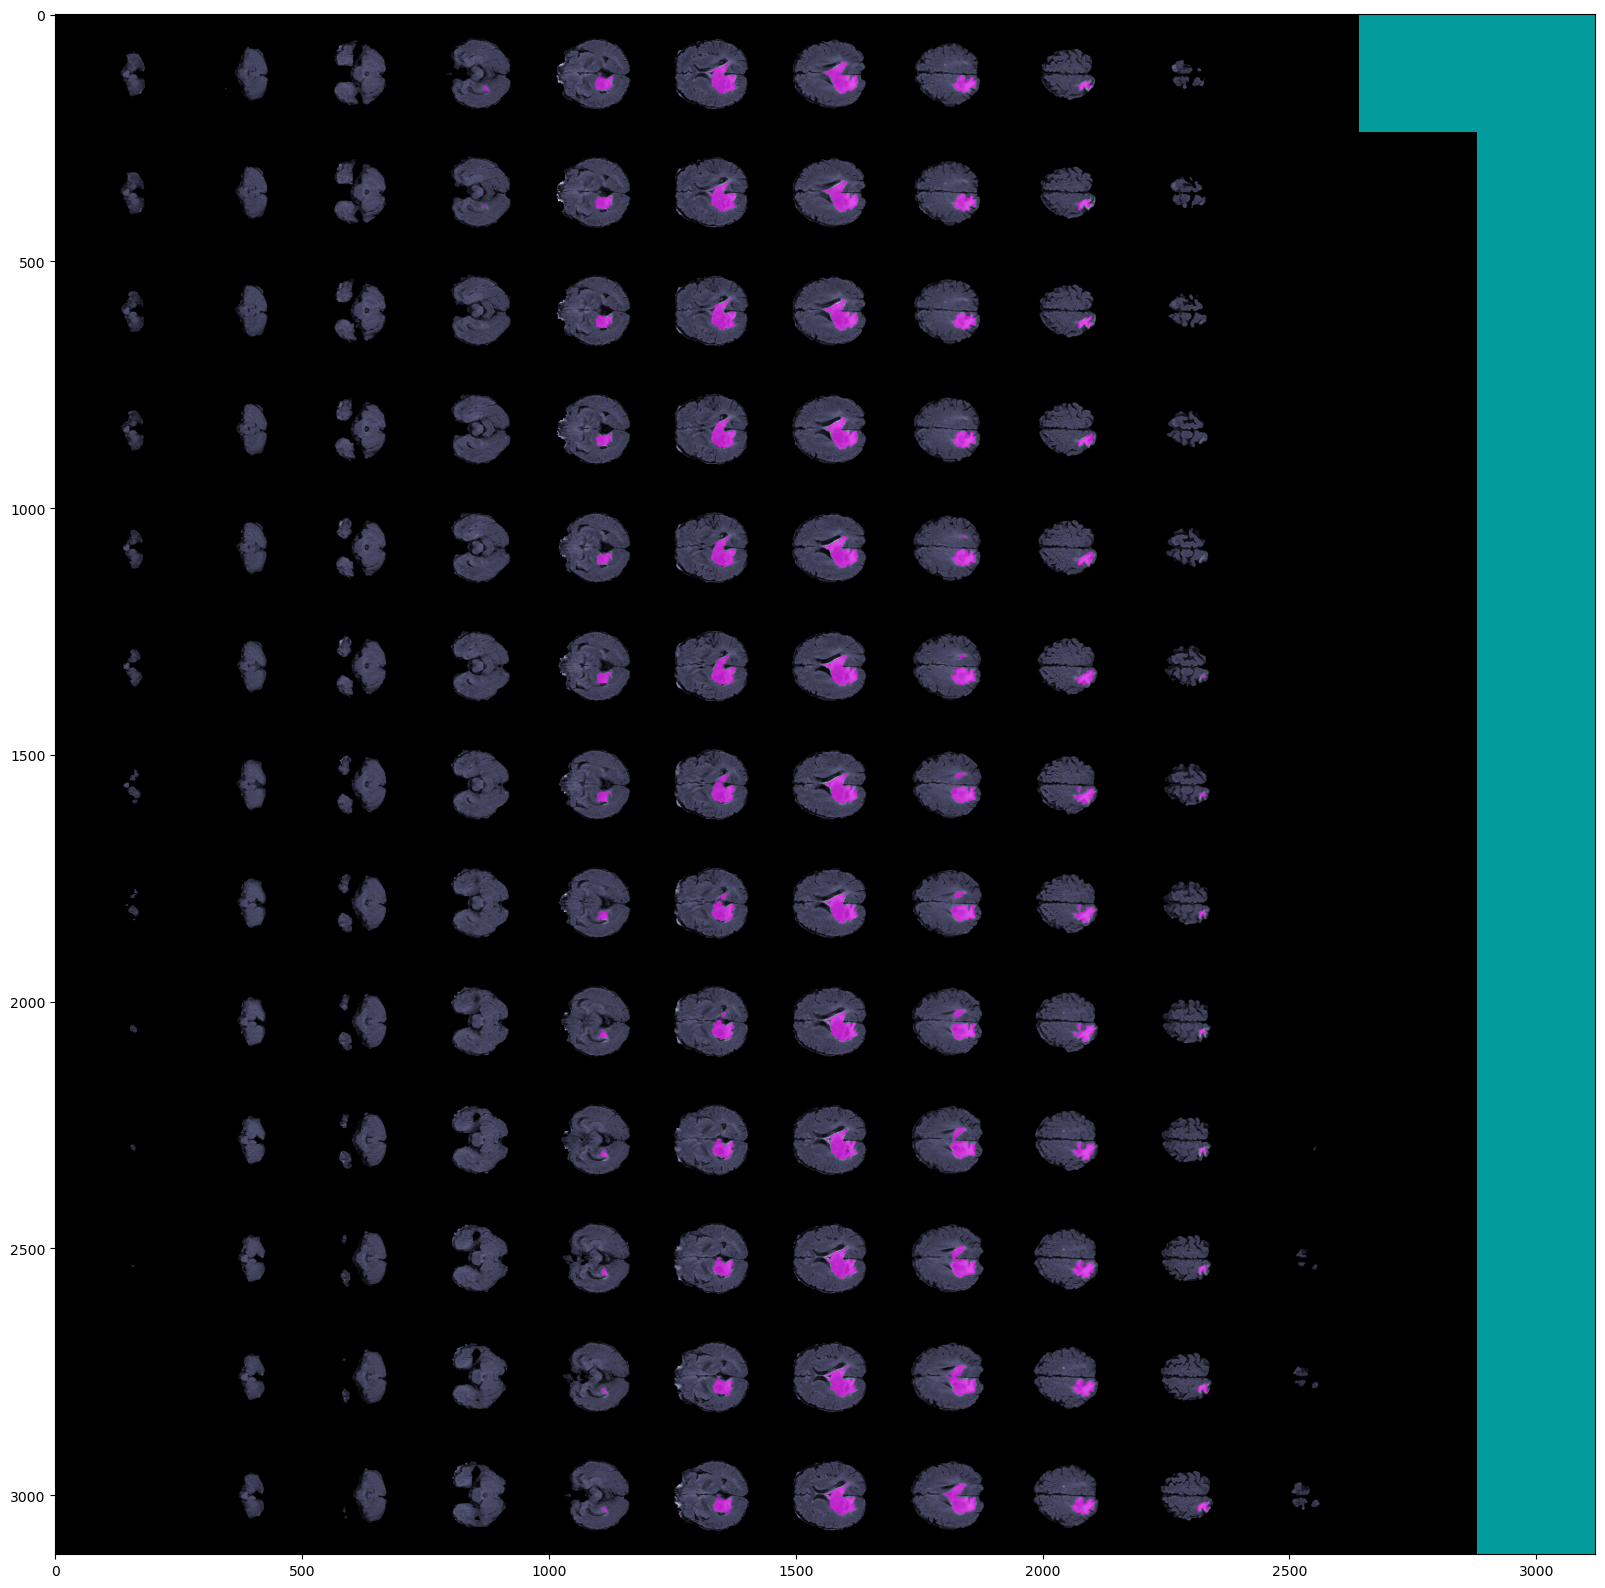

In [ ]:
img_tensor = data['image'].squeeze()[0].cpu().detach().numpy()
mask_tensor = data['mask'].squeeze()[0].squeeze().cpu().detach().numpy()

print("Num uniq Image values :", len(np.unique(img_tensor, return_counts=True)[0]))
print("Min/Max Image values:", img_tensor.min(), img_tensor.max())
print("Num uniq Mask values:", np.unique(mask_tensor, return_counts=True))

image = np.rot90(montage(img_tensor))
mask = np.rot90(montage(mask_tensor))

fig, ax = plt.subplots(1, 1, figsize = (20, 20))
ax.imshow(image, cmap ='bone')
ax.imshow(np.ma.masked_where(mask == False, mask),
           cmap='cool', alpha=0.6)

In [ ]:
img_tensor.shape
mask_tensor.shape

image = np.rot90(montage(img_tensor))
mask = np.rot90(montage(mask_tensor))

# Metrics and Loss metrics

In [ ]:
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:

    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


class Meter:
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []

    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)

        self.dice_scores.append(dice)
        self.iou_scores.append(iou)

    def get_metrics(self) -> np.ndarray:

        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou


class DiceLoss(nn.Module):
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:

        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)

        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score


class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:

        # logits are the images
        # target are the masks
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)
        return bce_loss + dice_loss
class enhense_loss(nn.Module):


    def __init__(self, weight=1.0, ignore_index=None, reduction='mean'):
        super(enhense_loss, self).__init__()
        assert reduction in ['none', 'mean', 'sum']
        self.ignore_index = ignore_index
        weight = float(weight)
        self.weight = weight
        self.reduction = reduction
        self.smooth = 0.01

    def forward(self, output, target):
        assert output.shape[0] == target.shape[0], "output & target batch size don't match"

        if self.ignore_index is not None:
            valid_mask = (target != self.ignore_index).float()
            output = output.mul(valid_mask)  # can not use inplace for bp
            target = target.float().mul(valid_mask)

        batch_size = output.size(0)
        output = output.view(batch_size, -1)
        target = target.view(batch_size, -1)

        output = torch.sigmoid(output)
        # avoid `nan` loss
        eps = 1e-6
        output = torch.clamp(output, min=eps, max=1.0 - eps)
        # soft label
        target = torch.clamp(target, min=self.smooth, max=1.0 - self.smooth)

        # loss = self.bce(output, target)
        loss = -self.weight * target.mul(torch.log(output)) - ((1.0 - target).mul(torch.log(1.0 - output)))
        if self.reduction == 'mean':
            loss = torch.mean(loss)
        elif self.reduction == 'sum':
            loss = torch.sum(loss)
        elif self.reduction == 'none':
            loss = loss
        else:
            raise NotImplementedError
        return loss

class Proposed_Loss(nn.Module):
    def __init__(self):
        super(Proposed_Loss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:

        # logits are the images
        # target are the masks
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)
        enhense_loss_=self.enhense_loss(logits, targets)
        return bce_loss + dice_loss+enhense_loss_
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray, # output of the model in an array format
               truth: np.ndarray,# masks
               treshold: float = 0.5, # threshold to whether segment / not
               eps: float = 1e-9, # smooth
               classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    scores = {key: list() for key in classes}

    num = probabilities.shape[0]

    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)

    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

# 3D Densely Net

In [ ]:
upsample = lambda x, size: F.interpolate(x, size, mode='bilinear', align_corners=False)
checkpoint = lambda func, *inputs: cp.checkpoint(func, *inputs, preserve_rng_state=True)
batchnorm_momentum = 0.05
batchnorm_momentum_ckpt = min(np.roots([-1, 2, -batchnorm_momentum]))
use_batchnorm = True
avg_pooling_k = 2
use_dws_up = False
use_dws_down = False
checkpoint_stem = True
use_pyl_in_spp = True
checkpoint_upsample = False

def get_pyramid_loss_scales(downsampling_factor, upsampling_factor):
    num_scales = int(math.log2(downsampling_factor // upsampling_factor))
    scales = [downsampling_factor]
    for i in range(num_scales - 1):
        assert scales[-1] % 2 == 0
        scales.append(scales[-1] // 2)
    return scales

def _batchnorm_factory(num_maps, momentum):
    return nn.BatchNorm2d(num_maps, eps=1e-5, momentum=momentum)

def _checkpoint_unit_nobt(bn, relu, conv):
    def func(*x):
        x = torch.cat(x, 1)
        return conv(relu(bn(x)))
    return func

def _checkpoint_unit(bn1, relu1, conv1, bn2, relu2, conv2):
    def func(*x):
        x = torch.cat(x, 1)
        x = conv1(relu1(bn1(x)))
        return conv2(relu2(bn2(x)))
    return func

class _Transition(nn.Sequential):
    @staticmethod
    def _checkpoint_function(bn, relu, conv, pool):
        def func(inputs):
            return pool(conv(relu(bn(inputs))))
        return func

    def __init__(self, num_input_features, num_output_features, stride=2, checkpointing=False):
        super(_Transition, self).__init__()
        self.stride = stride
        if use_batchnorm:
            m = batchnorm_momentum_ckpt if checkpointing else batchnorm_momentum
            self.add_module('norm', _batchnorm_factory(num_input_features, m))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        if stride > 1:
            if avg_pooling_k == 2:
                self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=stride))
            elif avg_pooling_k == 3:
                self.add_module('pool', nn.AvgPool2d(kernel_size=3, stride=stride,
            					padding=1, ceil_mode=False, count_include_pad=False))
        else:
            self.pool = lambda x: x
        self.checkpointing = checkpointing
        if checkpointing:
            self.func = _Transition._checkpoint_function(self.norm, self.relu, self.conv, self.pool)

    def forward(self, x):
        if self.checkpointing and self.training:
            return checkpoint(self.func, x)
        else:
            return super(_Transition, self).forward(x)

class _BNReluConv(nn.Sequential):
    @staticmethod
    def _checkpoint_function(bn, relu, conv):
        def func(inputs):
            return conv(relu(bn(inputs)))
        return func

    def __init__(self, num_maps_in, num_maps_out, k=3, output_conv=False,
                 dilation=1, drop_rate=0, checkpointing=False):
        super(_BNReluConv, self).__init__()
        self.drop_rate = drop_rate
        if use_batchnorm:
            m = batchnorm_momentum_ckpt if checkpointing else batchnorm_momentum
            self.add_module('norm', _batchnorm_factory(num_maps_in, m))
        self.add_module('relu', nn.ReLU(inplace=True))
        padding = ((k-1) // 2) * dilation
        if k >= 3 and use_dws_up:
            self.add_module('conv', SeparableConv2d(num_maps_in, num_maps_out, kernel_size=k,
                padding=padding, bias=output_conv, dilation=dilation))
        else:
            self.add_module('conv', nn.Conv2d(num_maps_in, num_maps_out, kernel_size=k,
                            padding=padding, bias=output_conv, dilation=dilation))
        self.checkpointing = checkpointing
        if checkpointing:
            self.func = _BNReluConv._checkpoint_function(self.norm, self.relu, self.conv)

    def forward(self, x):
        if self.checkpointing and self.training:
            x = checkpoint(self.func, x)
        else:
            x = super(_BNReluConv, self).forward(x)
        return x

class SpatialPyramidPooling(nn.Module):
    def __init__(self, conv_class, upsample_func, num_maps_in, bt_size=512, level_size=128,
                 out_size=256, grids=[6,3,2,1], square_grid=False):
        super(SpatialPyramidPooling, self).__init__()
        self.upsample = upsample_func
        self.grids = grids
        self.num_levels = len(grids)
        self.square_grid = square_grid
        self.spp = nn.Sequential()
        self.spp.add_module('spp_bn', conv_class(num_maps_in, bt_size, k=1))
        num_features = bt_size
        final_size = num_features
        for i in range(self.num_levels):
            final_size += level_size
            self.spp.add_module('spp'+str(i), conv_class(num_features, level_size, k=1))
        self.spp.add_module('spp_fuse', conv_class(final_size, out_size, k=1))

    def forward(self, x):
        levels = []
        target_size = x.size()[2:4]
        ar = target_size[1] / target_size[0]
        x = self.spp[0].forward(x)
        levels.append(x)
        num = len(self.spp) - 1
        for i in range(1, num):
            if not self.square_grid:
                grid_size = (self.grids[i-1], max(1, round(ar*self.grids[i-1])))
                x_pooled = F.adaptive_avg_pool2d(x, grid_size)
            else:
                x_pooled = F.adaptive_avg_pool2d(x, self.grids[i-1])
            level = self.spp[i].forward(x_pooled)
            level = self.upsample(level, target_size)
            levels.append(level)
        x = torch.cat(levels, 1)
        return self.spp[-1].forward(x)

class UpsampleResidual(nn.Module):
    def __init__(self, conv_class, upsample_func, num_maps_in, skip_maps_in, num_maps_out, k,
                 produce_aux=False, num_classes=0, dws_conv=False):
        super(UpsampleResidual, self).__init__()
        self.upsample_func = upsample_func
        self.bottleneck = conv_class(skip_maps_in, num_maps_in, k=1)
        self.produce_aux = produce_aux
        self.has_blend_conv = num_maps_out > 0
        self.num_maps_out = num_maps_in
        if num_maps_out != num_maps_in:
            self.skip_bt = conv_class(num_maps_in, num_maps_out, k=1)
        else:
            self.skip_bt = None
        if produce_aux:
            self.aux_logits = conv_class(num_maps_in, num_classes, k=1, output_conv=True)
        if self.has_blend_conv:
            self.num_maps_out = num_maps_out
            bt_maps = 128
            self.blend_bt = None
            if not dws_conv and k >=3 and num_maps_in > bt_maps:
                self.blend_bt = conv_class(num_maps_in, bt_maps, k=1)
                num_maps_in = bt_maps
            self.blend_conv = conv_class(num_maps_in, num_maps_out, k=k)

    def forward(self, bottom, skip):
        skip = self.bottleneck(skip)
        skip_size = skip.size()[2:4]
        if self.produce_aux:
            aux = self.aux_logits(bottom)

        bottom = self.upsample_func(bottom, skip_size)
        x = skip
        x += bottom

        if self.has_blend_conv:
            if self.blend_bt is not None:
                x = self.blend_bt(x)
            x = self.blend_conv(x)
        if self.skip_bt is not None:
            bottom = self.skip_bt(bottom)
        x += bottom
        if self.produce_aux:
            return x, aux
        return x

class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate,
                 dilation=1, checkpointing=True):
        super(_DenseLayer, self).__init__()
        m = batchnorm_momentum_ckpt if checkpointing else batchnorm_momentum
        bottleneck_size = bn_size * growth_rate
        self.add_module('norm1', _batchnorm_factory(num_input_features, m))
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bottleneck_size,
                        kernel_size=1, stride=1, bias=False))
        num_feats = bottleneck_size
        self.add_module('norm2', _batchnorm_factory(num_feats, m))
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(num_feats, growth_rate, kernel_size=3,
                            stride=1, padding=dilation, bias=False, dilation=dilation))
        self.drop_rate = drop_rate
        self.checkpointing = checkpointing
        if checkpointing:
            if len(self) == 6:
                self.conv_func = _checkpoint_unit(self.norm1, self.relu1, self.conv1,
                                                  self.norm2, self.relu2, self.conv2)
            else:
                self.conv_func = _checkpoint_unit_nobt(self.norm2, self.relu2, self.conv2)

    def forward(self, x):
        if self.checkpointing:
            if self.training:
                x = checkpoint(self.conv_func, *x)
            else:
                x = self.conv_func(*x)
        else:
            x = super(_DenseLayer, self).forward(x)

        if self.drop_rate > 0:
            x = F.dropout(x, p=self.drop_rate, training=self.training, inplace=True)

        return x


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate,
                 split=False, dilation=1, checkpointing=True):
        super(_DenseBlock, self).__init__()
        self.checkpointing = checkpointing
        self.split = split

        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate, growth_rate=growth_rate, bn_size=bn_size,
                drop_rate=drop_rate, dilation=dilation, checkpointing=checkpointing)
            self.add_module('denselayer%d' % (i + 1), layer)
        if split:
            self.split_size = num_input_features + (num_layers // 2) * growth_rate
            k = avg_pooling_k
            pad = (k-1) // 2
            self.pool_func = lambda x: F.avg_pool2d(x, k, 2, padding=pad, ceil_mode=False,
                                                    count_include_pad=False)

    def forward(self, x):
        if self.checkpointing:
            x = [x]
        for i, layer in enumerate(self.children()):
            if self.split and len(self) // 2 == i:
                if self.checkpointing:
                    split = torch.cat(x, 1)
                    x = [self.pool_func(split)]
                else:
                    split = x
                    x = self.pool_func(split)
            if self.checkpointing:
                x.append(layer(x))
            else:
                x = torch.cat([x, layer(x)], 1)
        if self.checkpointing:
            x = torch.cat(x, 1)
        if self.split:
            return x, split
        else:
            return x

class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0):
        super(DenseNet, self).__init__()
        batchnorm_momentum_ckpt = min(np.roots([-1, 2, -batchnorm_momentum]))
        self.first_stride = 2
        self.num_classes = 4
        self.num_logits = 4
        self.checkpointing = True
        self.growth_rate = growth_rate
        self.block_config = block_config
        self.num_blocks = len(block_config)
        self.growth_rate = growth_rate
        self.features = nn.Sequential()
        self.checkpoint_stem = True
        self.features.add_module('conv0', nn.Conv2d(4, num_init_features, kernel_size=7,
                                 stride=self.first_stride, padding=3, bias=False))
        m = batchnorm_momentum_ckpt
        self.features.add_module('norm0', _batchnorm_factory(num_init_features, m))
        self.features.add_module('relu0', nn.ReLU(inplace=True))
        self.features.add_module('pool0', nn.MaxPool2d(kernel_size=2, stride=2))
        self.first_block_idx = len(self.features)
        self.first_ckpt_func = self._checkpoint_segment(0, self.first_block_idx)
        self.random_init = []
        self.fine_tune = []
        self.fine_tune.append(self.features)
        splits = [False, False, False, False]
        up_sizes = [256, 256, 128]
        spp_square_grid = False
        spp_grids = [8,4,2,1]
        self.spp_size = 512
        bt_size = 512
        level_size = 128
        dilations = [1] * len(block_config)
        strides = [2] * (len(block_config) - 1)
        num_downs = self.first_stride + strides.count(2) + sum(splits)
        num_ups = len(up_sizes)
        self.downsampling_factor = 2**num_downs
        self.upsampling_factor = 2**(num_downs-num_ups)
        self.use_upsampling_path = True
        skip_sizes = []
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers, num_input_features=num_features, bn_size=bn_size,
                growth_rate=growth_rate, drop_rate=0, split=splits[i],
                dilation=dilations[i], checkpointing=self.checkpointing)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if block.split and self.use_upsampling_path:
                skip_sizes.append(block.split_size)
            if i != len(block_config) - 1:
                if strides[i] > 1 and self.use_upsampling_path:
                    skip_sizes.append(num_features)
                trans = _Transition(
                    num_input_features=num_features, num_output_features=num_features // 2,
                    stride=strides[i], checkpointing=self.checkpointing)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2
        self.use_aux = False
        self.spp = SpatialPyramidPooling(
            _BNReluConv, upsample, num_features, bt_size, level_size,
            self.spp_size, spp_grids, spp_square_grid)
        self.random_init.append(self.spp)
        num_features = self.spp_size
        if self.use_aux:
            self.pyramid_loss_scales = get_pyramid_loss_scales(
                    args.downsampling_factor, args.upsampling_factor)
            spp_scales = []
            for scale in reversed(spp_grids):
                assert args.crop_size % scale == 0
                spp_scales.append(args.crop_size // scale)
            self.pyramid_loss_scales = spp_scales + self.pyramid_loss_scales
        if self.use_upsampling_path:
            up_convs = [3] * len(up_sizes)
            self.upsample_layers = nn.Sequential()
            self.random_init.append(self.upsample_layers)
            assert len(up_sizes) == len(skip_sizes)
            for i in range(num_ups):
                upsample_unit = UpsampleResidual(
                    _BNReluConv, upsample, num_features, skip_sizes[-1-i], up_sizes[i],
                    up_convs[i], False, self.num_classes)
                num_features = upsample_unit.num_maps_out
                self.upsample_layers.add_module('upsample_'+str(i), upsample_unit)
        self.logits = _BNReluConv(num_features, self.num_logits, k=1, output_conv=True,
                                  checkpointing=self.checkpointing)
        self.random_init.append(self.logits)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        nn.init.xavier_normal_(self.logits.conv.weight.data)
        if self.use_aux and self.use_upsampling_path:
            for module in self.upsample_layers:
                nn.init.xavier_normal_(module.aux_logits.conv.weight.data)


    def forward(self, x, target_size=None):
        skip_layers = []
        if target_size is None:
            target_size = x.size()[2:4]

        if not self.training or not self.checkpoint_stem:
            for i in range(self.first_block_idx+1):
                x = self.features[i].forward(x)
        else:
            x = checkpoint(self.first_ckpt_func, x)
            x = self.features[self.first_block_idx].forward(x)
        for i in range(self.first_block_idx+1, len(self.features), 2):
            if self.features[i].stride > 1 and self.use_upsampling_path:
                skip_layers.append(x)
            x = self.features[i].forward(x)
            x = self.features[i+1].forward(x)
            if isinstance(x, tuple) and self.use_upsampling_path:
                x, split = x
                skip_layers.append(split)

        x = self.spp(x)

        aux_logits = []
        if self.use_upsampling_path:
            for i, up in enumerate(self.upsample_layers):
                x = up(x, skip_layers[-1-i])
                if self.use_aux:
                    x, aux = x
                    aux_logits.append(aux)

        x = self.logits(x)
        x = upsample(x, target_size)

        return x, aux_logits

    def _checkpoint_segment(self, start, end):
        def func(x):
            for i in range(start, end):
                x = self.features[i](x)
            return x
        return func

    def forward_loss(self, batch, return_outputs=False):
        x = batch['image']
        logits, aux_logits = self.forward(x)
        if not self.training:
            aux_logits = []
        self.output = logits
        loss = losses.segmentation_loss(logits, aux_logits, batch, self.args.aux_loss_weight,
                                        self.dataset.ignore_id, equal_level_weights=use_pyl_in_spp)
        loss, self.aux_losses = loss
        if return_outputs:
            return loss, (logits, aux_logits)
        return loss

class SemSegModel(nn.Module):
    def __init__(self, backbone, num_classes):
        super(SemSegModel, self).__init__()
        self.backbone = backbone

    def forward(self, image):
        logits, additional = self.backbone(image)
        nonlin = nn.LogSoftmax(1)
        return nonlin(logits)

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            # Convlution set one
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            # Convlution set two
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)

          )

    def forward(self,x):
        return self.double_conv(x)


class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        # max pooling 3d + doubleConv
        return self.encoder(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()

        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class Densely3d(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 8 * n_channels)

        self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 2 * n_channels)
        self.dec3 = Up(4 * n_channels, n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        mask = self.dec1(x5, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)

        return mask

# Trainer

In [ ]:
class Trainer:
    def __init__(self,
                 net: nn.Module,
                 dataset: torch.utils.data.Dataset,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 fold: int,
                 num_epochs: int,
                 path_to_csv: str,
                 display_plot: bool = True,
                ):

        """Initialization."""
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs

        self.dataloaders = {
            phase: get_dataloader(
                dataset = dataset,
                path_to_csv = path_to_csv,
                phase = phase,
                fold = fold,
                batch_size = batch_size,
                num_workers = 4
            )
            for phase in self.phases
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}

    def _compute_loss_and_outputs(self,
                                  images: torch.Tensor,
                                  targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images)
        loss = self.criterion(logits, targets)
        return loss, logits

    def _do_epoch(self, epoch: int, phase: str):
        print(f"{phase} epoch: {epoch} | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        for itr, data_batch in enumerate(dataloader):
            images, targets = data_batch['image'], data_batch['mask']
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                # Backpropagating the losses generated to train the Unet
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()

            running_loss += loss.item()
            print(f"running loss of epoch {epoch} is : ", running_loss)
            meter.update(logits.detach().cpu(),
                         targets.detach().cpu()
                        )

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()

        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        return epoch_loss

    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                print(f"BCEDiceLoss for epoch {epoch} is : " , val_loss )
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()

            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")
            print()
        self._save_train_history()

    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,

            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]}
            """,

            f"""
            train jaccard score {self.jaccard_scores['train'][-1]}
            val jaccard score {self.jaccard_scores['val'][-1]}
            """,
        ]

        clear_output(True)
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")

            plt.tight_layout()
            plt.show()

    def load_predtrain_model(self,
                             state_path: str):
        self.net.load_state_dict(torch.load(state_path))
        print("Predtrain model loaded")

    def _save_train_history(self):
        """writing model weights and training logs to files."""
        torch.save(self.net.state_dict(),
                   f"last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i]
                     for i in list(range(len(logs_)))
                     for key in logs_[i]
                    ]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv("train_log.csv", index=False)

# Training the Densely3d

In [ ]:
nodel = Densely3d(in_channels=4, n_classes=3, n_channels=24).to('cuda')

In [ ]:
trainer = Trainer(net=nodel,
                  dataset=BratsDataset,
                  criterion=Proposed_Loss(),
                  lr=1e-4,
                  accumulation_steps=4,
                  batch_size=1,
                  fold=0,
                  num_epochs=1,
                  path_to_csv = config.path_to_csv,)

if config.pretrained_model_path is not None:
    trainer.load_predtrain_model(config.pretrained_model_path)

    # if need - load the logs.
    train_logs = pd.read_csv(config.train_logs_path)
    trainer.losses["train"] =  train_logs.loc[:, "train_loss"].to_list()
    trainer.losses["val"] =  train_logs.loc[:, "val_loss"].to_list()
    trainer.dice_scores["train"] = train_logs.loc[:, "train_dice"].to_list()
    trainer.dice_scores["val"] = train_logs.loc[:, "val_dice"].to_list()
    trainer.jaccard_scores["train"] = train_logs.loc[:, "train_jaccard"].to_list()
    trainer.jaccard_scores["val"] = train_logs.loc[:, "val_jaccard"].to_list()

device: cuda
Predtrain model loaded


In [ ]:
# training time(t0) starts
t0 = time.time()

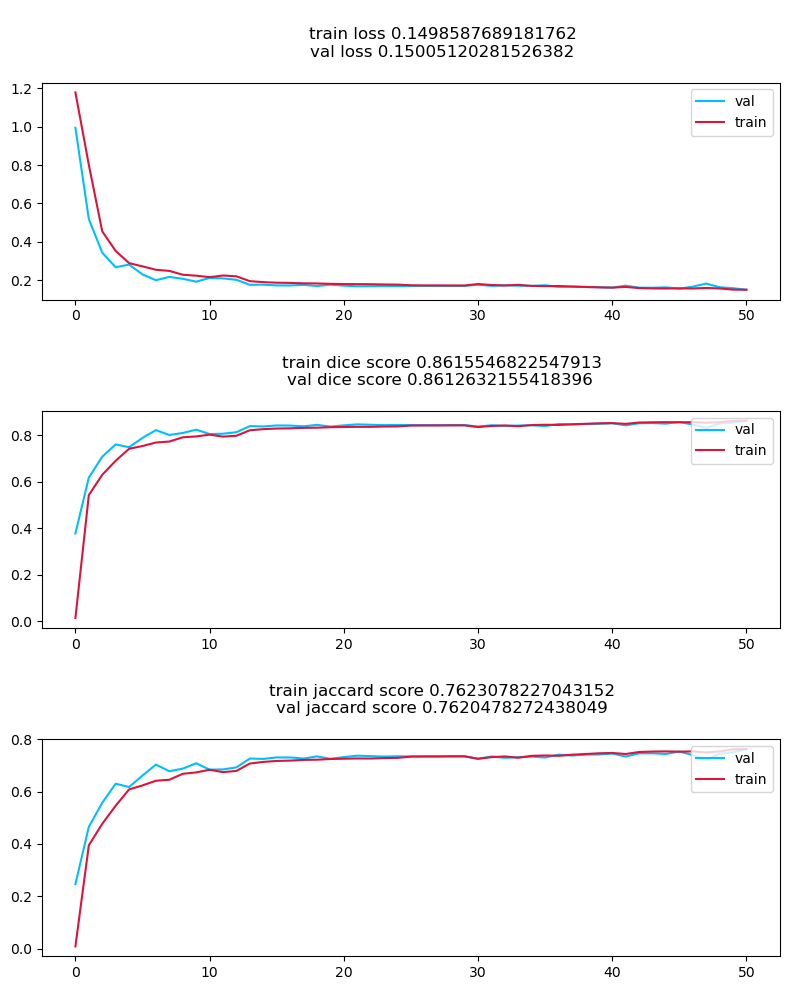


####################
Saved new checkpoint
####################




In [ ]:
trainer.run()

In [ ]:
# total training time(tt)
t1 = time.time()
tt = t1 - t0
print("Training time : ",tt)

Training time :  1253.961135149002


# Model serialization

In [ ]:
torch.save(nodel.state_dict(), 'Densely3d_state_dict.pth')
torch.save(nodel, 'Densely3d_model.pth')

In [ ]:
gc.collect()

10461

# Trainer performance evaluation

In [ ]:
# Loading the serialized model to avoid computation
nodel = torch.load('/kaggle/working/Densely3d_model.pth')

# Turning on Evaluation mode of the model
nodel.eval()

Densely3d(
  (conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(4, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm(8, 24, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): GroupNorm(8, 24, eps=1e-05, affine=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc1): Down(
    (encoder): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv3d(24, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): GroupNorm(8, 48, eps=1e-05, affine=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(48, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (4): GroupNorm(8, 48, eps=1e-05, affine=True)
          (5): ReLU(inplace=True)
        )
      )
    )
  )
  (enc2): Down(


In [ ]:
test_dataloader = get_dataloader(dataset=BratsDataset, path_to_csv='train_data.csv', phase="valid", fold=1)
len(test_dataloader)

34

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

gc.collect()
def compute_metrics(model, dataloader, threshold=0.33):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0

    with torch.no_grad():  # Disable gradient calculations to save memory
        for data in dataloader:

            images, targets = data['image'], data['mask']
            images = images.to(device)
            targets = targets.to(device)

            logits = model(images)
            probabilities = torch.sigmoid(logits)
            predictions = (probabilities >= threshold).float()

            # Compute binary segmentation metrics
            true_positives += torch.sum((predictions == 1) & (targets == 1)).item()
            false_positives += torch.sum((predictions == 1) & (targets == 0)).item()
            true_negatives += torch.sum((predictions == 0) & (targets == 0)).item()
            false_negatives += torch.sum((predictions == 0) & (targets == 1)).item()

            counter += 1

            # Free memory by clearing intermediate variables
            del images, targets, logits, probabilities, predictions
            torch.cuda.empty_cache()

    return true_positives , false_positives , true_negatives , false_negatives

tp , fp , tn , fn  = compute_metrics(nodel, test_dataloader, threshold=0.33)

In [ ]:
print(f"True positives : {tp}")
print(f"False positives : {fp}")
print(f"True Negatives : {tn}")
print(f"False Negatives : {fn}")

True positives : 3577665
False positives : 552714
True Negatives : 905779815
False Negatives : 745806


# Confusion matrix

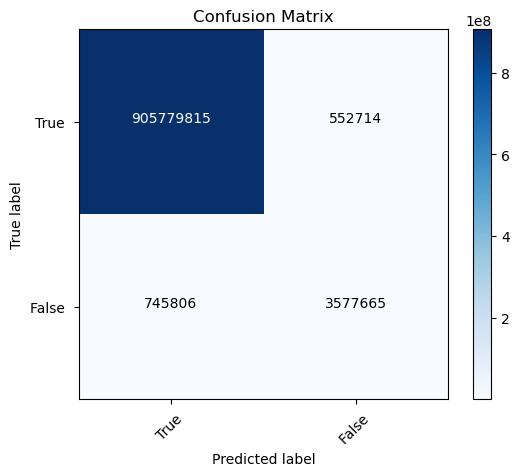

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(tp, fp, tn, fn):
    # Create confusion matrix array
    confusion_matrix = np.array([[tn, fp], [fn, tp]])

    # Set up labels for matrix
    labels = ['True ', 'False ']

    # Create color map
    cmap = plt.cm.Blues

    # Plot confusion matrix
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()

    # Add labels to matrix cells
    thresh = confusion_matrix.max() / 2.
    for i, j in np.ndindex(confusion_matrix.shape):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'), horizontalalignment='center', color='white' if confusion_matrix[i, j] > thresh else 'black')

    # Set tick labels
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    # Set axis labels
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    # Show plot
    plt.show()

plot_confusion_matrix(tp, fp, tn, fn)


## Evaluation metrics

In [ ]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

In [ ]:
print(f"Accuracy : {accuracy*100}")
print(f"Precision : {precision*100}")
print(f"Recall : {recall*100}")
print(f"F1 Score : {f1_score*100}")

Accuracy : 99.857408285895
Precision : 86.61832243481773
Recall : 82.74983225283574
F1 Score : 84.63989779804469


## Classification Report

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

gc.collect()

def compute_metrics(model, dataloader, num_entries, threshold=0.33):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    predictions = []

    # Counter to keep track of the number of entries processed
    counter = 0

    with torch.no_grad():
        for data in dataloader:
            if counter >= num_entries:
                break  # Stop processing entries if the desired number is reached

            images, targets = data['image'], data['mask']
            images = images.to(device)
            targets = targets.to(device)

            logits = model(images)
            probabilities = torch.sigmoid(logits)
            prediction = (probabilities >= threshold).float()

            prediction =  prediction.cpu()
            targets = targets.cpu()

            predictions.append(prediction)

            model.zero_grad()
            del images, targets, logits, probabilities, prediction
            torch.cuda.empty_cache()

            counter += 1

    # Compute confusion matrix
    y_true = np.concatenate([targets.cpu() for data in dataloader for targets in data['mask']])
    y_pred = np.concatenate([prediction.cpu() for data in dataloader for prediction in predictions])

    # y_true = np.concatenate([targets for targets in dataloader.dataset])
    # y_pred = np.concatenate([predictions for predictions in predictions])


    cm = confusion_matrix(y_true, y_pred)

    # Compute classification report
    class_names = ['Background', 'Tumor']
    report = classification_report(y_true, y_pred, target_names=class_names)

    # Return evaluation metrics, confusion matrix, and classification report
    evaluation_results = {
        'Confusion Matrix': cm,
        'Classification Report': report
    }

    return evaluation_results

num_entries = 5  # Specify the number of entries to evaluate
evaluation_results = compute_metrics(nodel, test_dataloader, num_entries, threshold=0.33)

# Print the evaluation results
for metric, value in evaluation_results.items():
    print(f'{metric}: {value}')


# Experiments and Results

In [ ]:
def compute_scores_per_classes(model,          # nodel which is Densely3d
                               dataloader,     # tuple consisting of ( id , image tensor , mask tensor )
                               classes):       # classes : WT , TC , ET

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            imgs, targets = data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()

            # Now finding the overlap between the raw prediction i.e. logit & the mask i.e. target & finding the dice & iou scores
            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)

            # storing both dice & iou scores in the list declared
            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes

In [ ]:
val_dataloader = get_dataloader(BratsDataset, 'train_data.csv', phase='valid', fold=0)
len(dataloader)

In [ ]:
nodel.eval();

In [ ]:
%%time
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(
    nodel, val_dataloader, ['WT', 'TC', 'ET']
    )

In [ ]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']

val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard',
                                      'TC dice', 'TC jaccard',
                                      'ET dice', 'ET jaccard']]
val_metics_df.sample(5)

In [ ]:
colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF']
palette = sns.color_palette(colors, 6)

fig, ax = plt.subplots(figsize=(12, 6));
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax);
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15);
ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig("result1.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("result1.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

# Computing the brain tumour segmented masks

In [ ]:
def compute_results(model,
                    dataloader,
                    treshold=0.33):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results = {"Id": [],"image": [], "GT": [],"Prediction": []}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            id_, imgs, targets = data['Id'], data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits)

            predictions = (probs >= treshold).float()
            predictions =  predictions.cpu()
            targets = targets.cpu()

            results["Id"].append(id_)
            results["image"].append(imgs.cpu())
            results["GT"].append(targets)
            results["Prediction"].append(predictions)

            # only 5 pars
            if (i > 5):
                return results
        return results

In [ ]:
# prediction time starts(p0)
p0 = time.time()

In [ ]:
results = compute_results(
    nodel, val_dataloader, 0.33)

In [ ]:
# total prediction time(pt)
p1 = time.time()
pt = p1 - p0
print("Model prediction time ; ",pt )

In [ ]:
for id_, img, gt, prediction in zip(results['Id'][4:],
                    results['image'][4:],
                    results['GT'][4:],
                    results['Prediction'][4:]
                    ):

    print(id_)
    break

# Visualizing the predicted segmented masks

In [ ]:
show_result = ShowResult()
show_result.plot(img, gt, prediction)

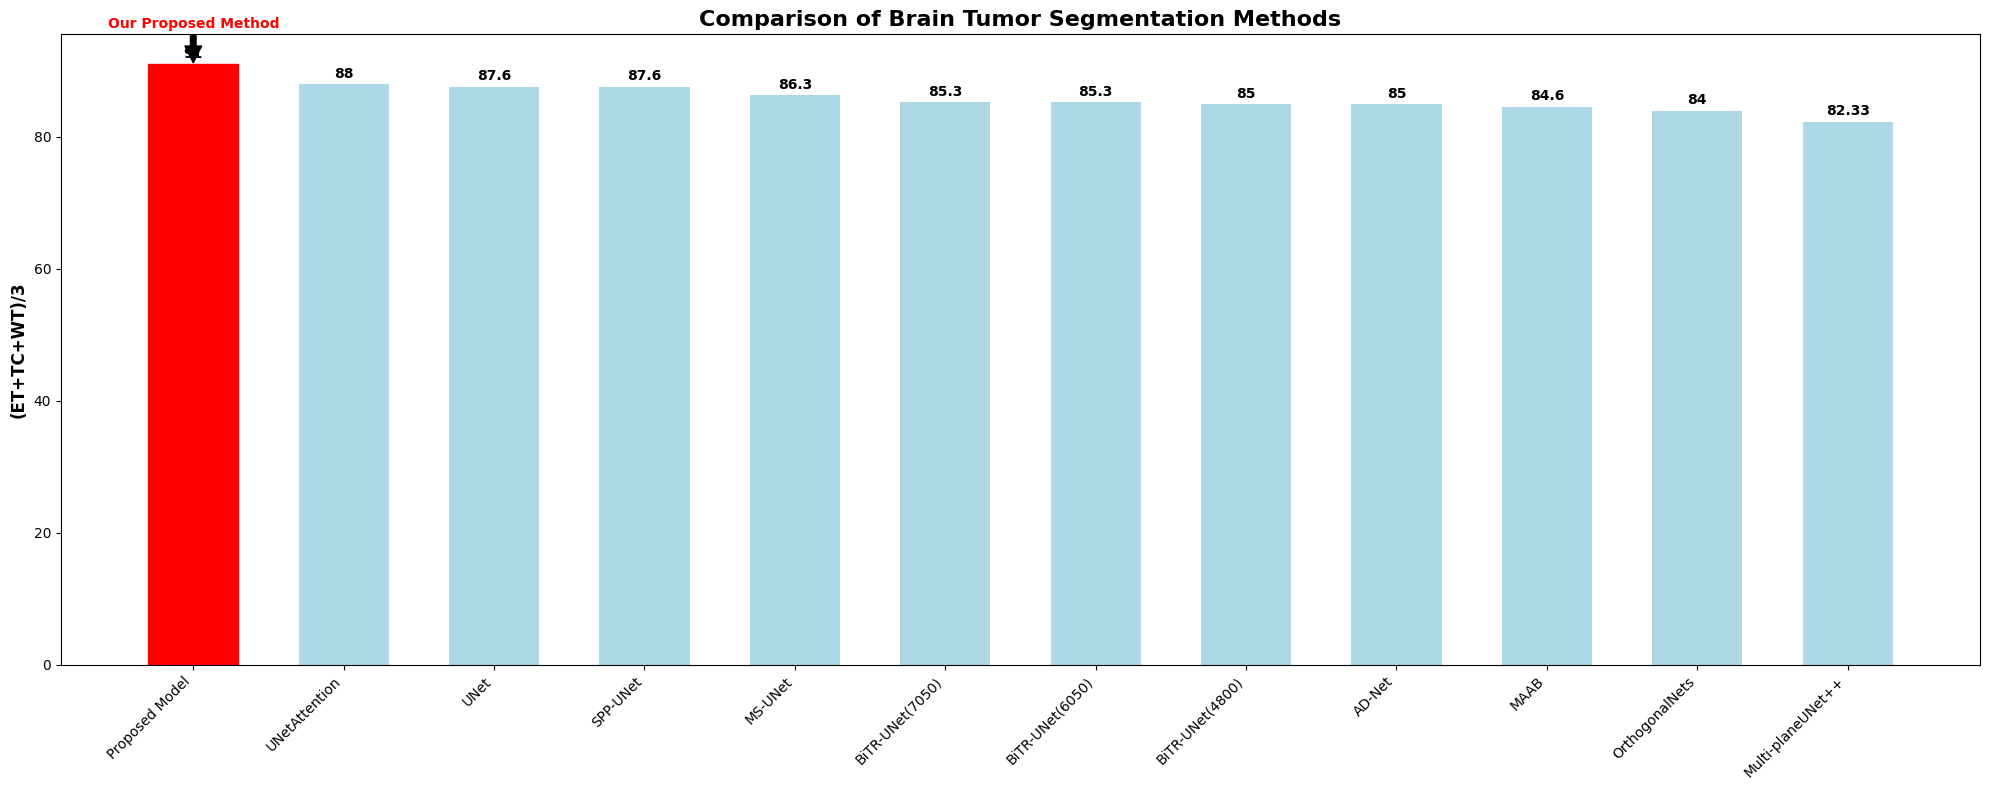

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.6
fig, ax = plt.subplots(figsize=(20, 8))

# set height of bar (sorted in descending order)
IT = [91, 88, 87.6, 87.6, 86.3, 85.3, 85.3, 85, 85, 84.6, 84, 82.33]
methods = ['Proposed Model', 'UNetAttention', 'UNet', 'SPP-UNet', 'MS-UNet', 'BiTR-UNet(7050)',
           'BiTR-UNet(6050)', 'AD-Net', 'BiTR-UNet(4800)', 'MAAB', 'OrthogonalNets', 'Multi-planeUNet++']

# Sort the data
sorted_data = sorted(zip(IT, methods), reverse=True)
IT_sorted, methods_sorted = zip(*sorted_data)

# Set position of bar on X axis
br1 = np.arange(len(IT_sorted))

# Make the plot
bars = plt.bar(br1, IT_sorted, color='lightblue', width=barWidth)

# Color for the proposed method
bars[0].set_color('red')

# Adding labels and title
plt.ylabel('(ET+TC+WT)/3', fontweight='bold', fontsize=12)
plt.title('Comparison of Brain Tumor Segmentation Methods', fontweight='bold', fontsize=16)
plt.xticks(br1, methods_sorted, rotation=45, ha='right', fontsize=10)

# Add value labels on the bars
for i, v in enumerate(IT_sorted):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

# Highlight the proposed method
plt.annotate('Our Proposed Method', xy=(0, IT_sorted[0]), xytext=(0, IT_sorted[0]+5),
             arrowprops=dict(facecolor='black', shrink=0.05),
             ha='center', va='bottom', fontweight='bold', color='red')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
